# Mini-projet n°2 - Conditional VAEs

L'objectif de ce projet est de définir et entraîner un Conditional VAE (CVAE). Nous allons tout d'abord définir ce qu'est un CVAE et la différence avec un VAE, puis définir et entraîner un CVAE sur le dataset Fashin-MNIST.

## Définition d'un CVAE

### Définition d'un VAE

Un Variational AutoEncoder (VAE) est un autoencoder qui suppose que les données sont produites de manière probabilistes $p(X|Z)$, avec $X$ les données et $Z$ le label associé. Les sortie de l'encoder sont des probabilités, dont on va en sortir la moyenne $\mu$ ainsi que la variance. 
Ainsi, l'encoder va apprendre $q(Z|X)$ alors que le decoder va apprendre $p(X|Z)$.

La fonction perte utilisée pour un VAE est 
$$Loss =  L(x, x') + \sum_{j=1}^{m} KL( q(z_j | x) \Vert \, p(z_j))$$

avec $L$ une fonction perte de reconstruction telle que la MSE ou BCE, et $KL : (f, f') \to KL(f, f')$ la divergence de Kullback-Leibler, qui admet un minimum en $f = f'$. Cette dernière fonction n'est pas symétrique. On suppose en général que $p(z_j) \sim \mathcal{N}(0,1)$

### Définition d'un CVAE

The conditional VAE (CVAE), inserts label information in the latent space to force a deterministic constrained representation of the learned data

https://creatis-myriad.github.io/tutorials/2022-09-12-tutorial-cvae.html#cvae


https://towardsdatascience.com/conditional-variational-autoencoders-for-text-to-image-generation-1996da9cefcb/


## Création du CVAE

In [1]:
# Maths
import matplotlib.pyplot as plt
import numpy as np

In [42]:
# Deep Learning
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from collections import Counter

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Importation des données

In [5]:
batch_size = 128

transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.FashionMNIST(
    root="./Fashion_MNIST",
    train=True,
    download=True,
    transform=transform
)

test_dataset = datasets.FashionMNIST(
    root="./Fashion_MNIST",
    train=False,
    download=True,
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [62]:
img, label = train_dataset[0]
print("Image shape :", img.shape)

classes = {0 : 'T-shirt/top', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress', 4: 'Coat',
    5 : 'Sandal', 6 : 'Shirt', 7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle Boot' }

print(classes)


Image shape : torch.Size([1, 28, 28])
{0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle Boot'}


Le jeu de données Fashion MNIST comporte 70 000 images labellisées de taille $28 \times 28$.
Il y a 10 classes différentes, qui représentes différentes vêtements : 
- T-shirt 
- Pantlons
- Pull
- Robes
- Manteau
- Sandales
- Chemises
- Chaussures / baskets
- Sac
- Bottes

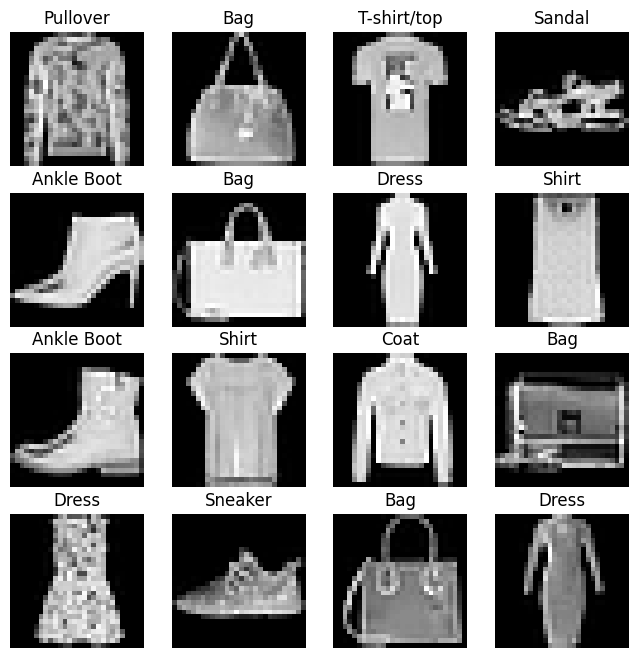

In [63]:
images, labels = next(iter(train_loader))

plt.figure(figsize=(8,8))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(images[i].squeeze(), cmap="gray")
    plt.title(classes[labels[i].item()])
    #plt.title(labels[i].item())
    plt.axis("off")
plt.show()


In [65]:
labels = [label for _, label in train_dataset]
count = Counter(labels)
print("Nombre d'images dans chaque classes dans le jeu d'apprentissage :")
for idx, c in count.items():
    print(f"- {classes[idx]} : {c}")

Nombre d'images dans chaque classes dans le jeu d'apprentissage :
- Ankle Boot : 6000
- T-shirt/top : 6000
- Dress : 6000
- Pullover : 6000
- Sneaker : 6000
- Sandal : 6000
- Trouser : 6000
- Shirt : 6000
- Coat : 6000
- Bag : 6000


In [66]:
labels = [label for _, label in test_dataset]
count = Counter(labels)
print("Nombre d'images dans chaque classes dans le jeu de test :")
for idx, c in count.items():
    print(f"- {classes[idx]} : {c}")

Nombre d'images dans chaque classes dans le jeu de test :
- Ankle Boot : 1000
- Pullover : 1000
- Trouser : 1000
- Shirt : 1000
- Coat : 1000
- Sandal : 1000
- Sneaker : 1000
- Dress : 1000
- Bag : 1000
- T-shirt/top : 1000


### Défintion du CVAE

In [67]:
class ConcatConditionalVAE(nn.Module):
    def __init__(self, latent_dim=128, num_classes=10):
        super().__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )

        self.flatten_size = 128 * 4 * 4

        # Conditional embedding
        self.label_embedding = nn.Embedding(num_classes, 32)

        # Latent space (with concatenated condition)
        self.fc_mu = nn.Linear(self.flatten_size + 32, latent_dim)
        self.fc_var = nn.Linear(self.flatten_size + 32, latent_dim)

        # Decoder
        self.decoder_input = nn.Linear(latent_dim + 32, 4 * 4 * 128)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 2, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def encode(self, x, c):
        x = self.encoder(x)
        c = self.label_embedding(c)
        # Concatenate condition with encoded input
        x = torch.cat([x, c], dim=1)

        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        return mu, log_var

    def sample(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, c):
        c = self.label_embedding(c)
        # Concatenate condition with latent vector
        z = torch.cat([z, c], dim=1)
        z = self.decoder_input(z)
        z = z.view(-1, 128, 4, 4)
        return self.decoder(z)

    def forward(self, x, c):
        mu, log_var = self.encode(x, c)
        z = self.sample(mu, log_var)
        return self.decode(z, c), mu, log_var

In [68]:
def loss_function(recon_x, x, mu, logvar, beta = 1) :
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + beta*KLD

In [69]:
class AdditiveConditionalVAE(nn.Module):
    def __init__(self, latent_dim=128, num_classes=10):
        super().__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )

        self.flatten_size = 128 * 4 * 4

        # Conditional embedding
        self.label_embedding = nn.Embedding(num_classes, self.flatten_size)

        # Latent space (without concatenation)
        self.fc_mu = nn.Linear(self.flatten_size, latent_dim)
        self.fc_var = nn.Linear(self.flatten_size, latent_dim)

        # Decoder condition embedding
        self.decoder_label_embedding = nn.Embedding(num_classes, latent_dim)

        # Decoder
        self.decoder_input = nn.Linear(latent_dim, 4 * 4 * 128)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 2, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def encode(self, x, c):
        x = self.encoder(x)
        c = self.label_embedding(c)
        # Add condition to encoded input
        x = x + c

        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, c):
        # Add condition to latent vector
        c = self.decoder_label_embedding(c)
        z = z + c
        z = self.decoder_input(z)
        z = z.view(-1, 128, 4, 4)
        return self.decoder(z)

    def forward(self, x, c):
        mu, log_var = self.encode(x, c)
        z = self.reparameterize(mu, log_var)
        return self.decode(z, c), mu, log_var

The CVAE encoder consists of 3 convolutional layers each followed by a ReLU non-linearity. The output of the encoder is then flattened. The class number is then passed through an embedding layer and added to the encoder output. The reparameterization trick is then used with 2 linear layers to obtain a μ and σ in the latent space. Once sampled, the output of the reparameterized latent space is passed to the decoder now concatenated with the class number embedding layer output. The decoder consists of 3 transposed convolutional layers. The first two contain a ReLU non-linearity with the last layer containing a sigmoid non-linearity. The output of the decoder is a 28×28 generated image.

The other model architecture follows the same approach but with adding the conditional input instead of concatenating. A major question was if adding or concatenating will lead to better reconstruction or generation results.

## Entraînement du CVAE

In [72]:
# Paramètres
latent_dim = 2
learning_rate = 1e-3
epochs = 30
beta = 1

In [71]:
vae_concat = ConcatConditionalVAE(latent_dim=latent_dim, num_classes=10)
vae_concat.to(device)
optimizer = optim.Adam(vae_concat.parameters(), lr=learning_rate)


for epoch in range(1, epochs + 1):
    vae_concat.train()
    running_loss = 0.0
    for batch_idx, (data, labels) in enumerate(train_loader):
        data = data.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae_concat(data, labels)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() 
    
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch {epoch}, Training loss: {epoch_loss:.4f}')

Epoch 1, Training loss: 284.0049
Epoch 2, Training loss: 259.3118
Epoch 3, Training loss: 257.1278
Epoch 4, Training loss: 256.0170
Epoch 5, Training loss: 255.2270
Epoch 6, Training loss: 254.6607
Epoch 7, Training loss: 254.2610
Epoch 8, Training loss: 253.9209
Epoch 9, Training loss: 253.6172
Epoch 10, Training loss: 253.4347
Epoch 11, Training loss: 253.1114
Epoch 12, Training loss: 252.9496
Epoch 13, Training loss: 252.7540
Epoch 14, Training loss: 252.6019
Epoch 15, Training loss: 252.4735
Epoch 16, Training loss: 252.3218
Epoch 17, Training loss: 252.1486
Epoch 18, Training loss: 252.0944
Epoch 19, Training loss: 251.9383
Epoch 20, Training loss: 251.8368
Epoch 21, Training loss: 251.7041
Epoch 22, Training loss: 251.6147
Epoch 23, Training loss: 251.4871
Epoch 24, Training loss: 251.4049
Epoch 25, Training loss: 251.3307
Epoch 26, Training loss: 251.2292
Epoch 27, Training loss: 251.1654
Epoch 28, Training loss: 251.0474
Epoch 29, Training loss: 250.9417
Epoch 30, Training loss

In [73]:
vae_add = AdditiveConditionalVAE(latent_dim=latent_dim, num_classes=10)
vae_add.to(device)
optimizer = optim.Adam(vae_add.parameters(), lr=learning_rate)


for epoch in range(1, epochs + 1):
    vae_add.train()
    running_loss = 0.0
    for batch_idx, (data, labels) in enumerate(train_loader):
        data = data.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae_add(data, labels)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() 
    
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch {epoch}, Training loss: {epoch_loss:.4f}')

Epoch 1, Training loss: 297.7212
Epoch 2, Training loss: 274.5755
Epoch 3, Training loss: 270.9190
Epoch 4, Training loss: 268.9106
Epoch 5, Training loss: 267.8566
Epoch 6, Training loss: 266.5770
Epoch 7, Training loss: 266.0325
Epoch 8, Training loss: 265.6614
Epoch 9, Training loss: 265.0149
Epoch 10, Training loss: 264.5252
Epoch 11, Training loss: 264.3547
Epoch 12, Training loss: 264.1359
Epoch 13, Training loss: 263.5915
Epoch 14, Training loss: 262.9750
Epoch 15, Training loss: 263.3603
Epoch 16, Training loss: 262.4347
Epoch 17, Training loss: 262.6511
Epoch 18, Training loss: 262.4800
Epoch 19, Training loss: 262.0292
Epoch 20, Training loss: 261.7491
Epoch 21, Training loss: 261.3704
Epoch 22, Training loss: 261.9788
Epoch 23, Training loss: 261.0199
Epoch 24, Training loss: 261.2614
Epoch 25, Training loss: 261.0355
Epoch 26, Training loss: 260.4961
Epoch 27, Training loss: 260.5035
Epoch 28, Training loss: 260.3833
Epoch 29, Training loss: 260.4372
Epoch 30, Training loss

In [89]:
def comparison_images(im1, title1, im2, title2, n_images=6):
    fig, ax = plt.subplots(2, n_images, figsize=(20, 7))
    
    for i in range(n_images):
        # Plot original images
        ax[0, i].imshow(im1[i], cmap='gray')
        ax[0, i].axis('off')    

        # Reconstructed images
        ax[1, i].imshow(im2[i], cmap='gray')
        ax[1, i].axis('off')
        
    ax[0, 0].set_title(title1)
    ax[1, 0].set_title(title2)
    
    plt.tight_layout()
    plt.show()

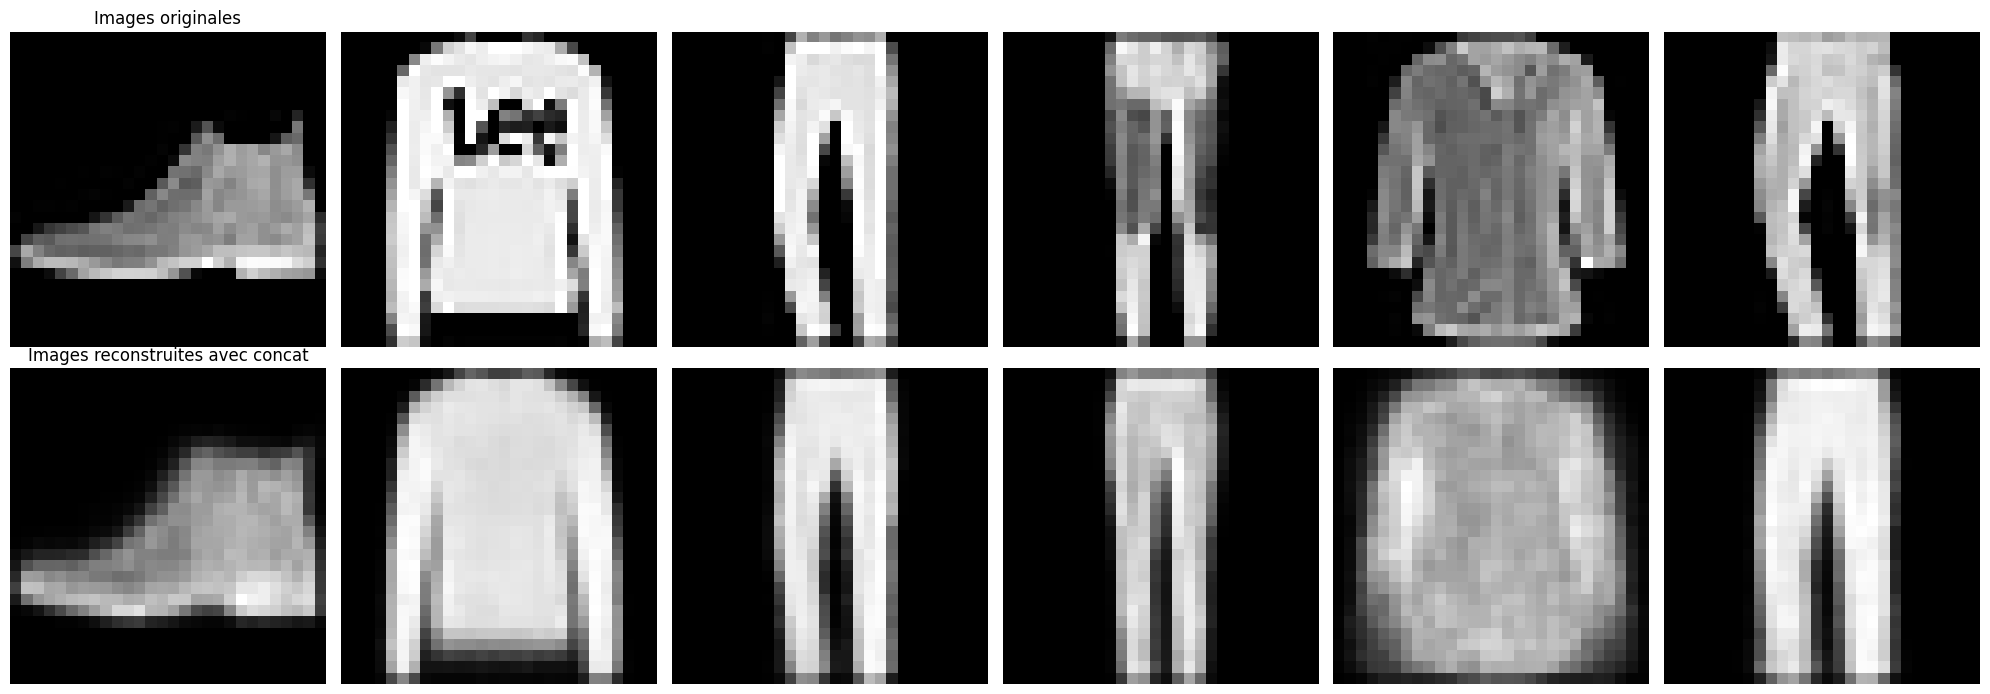

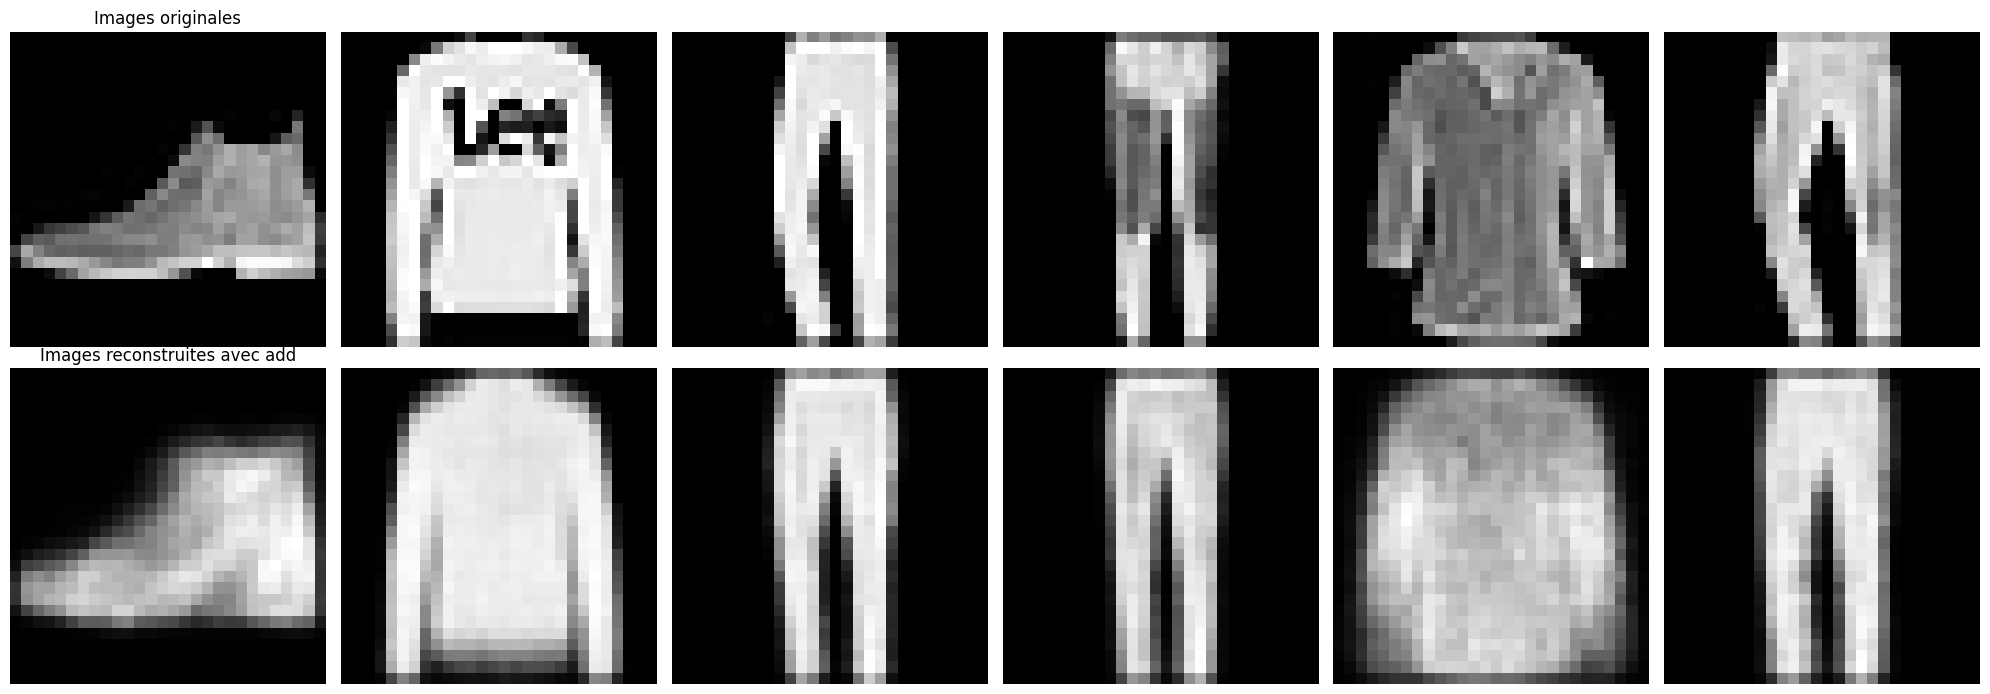

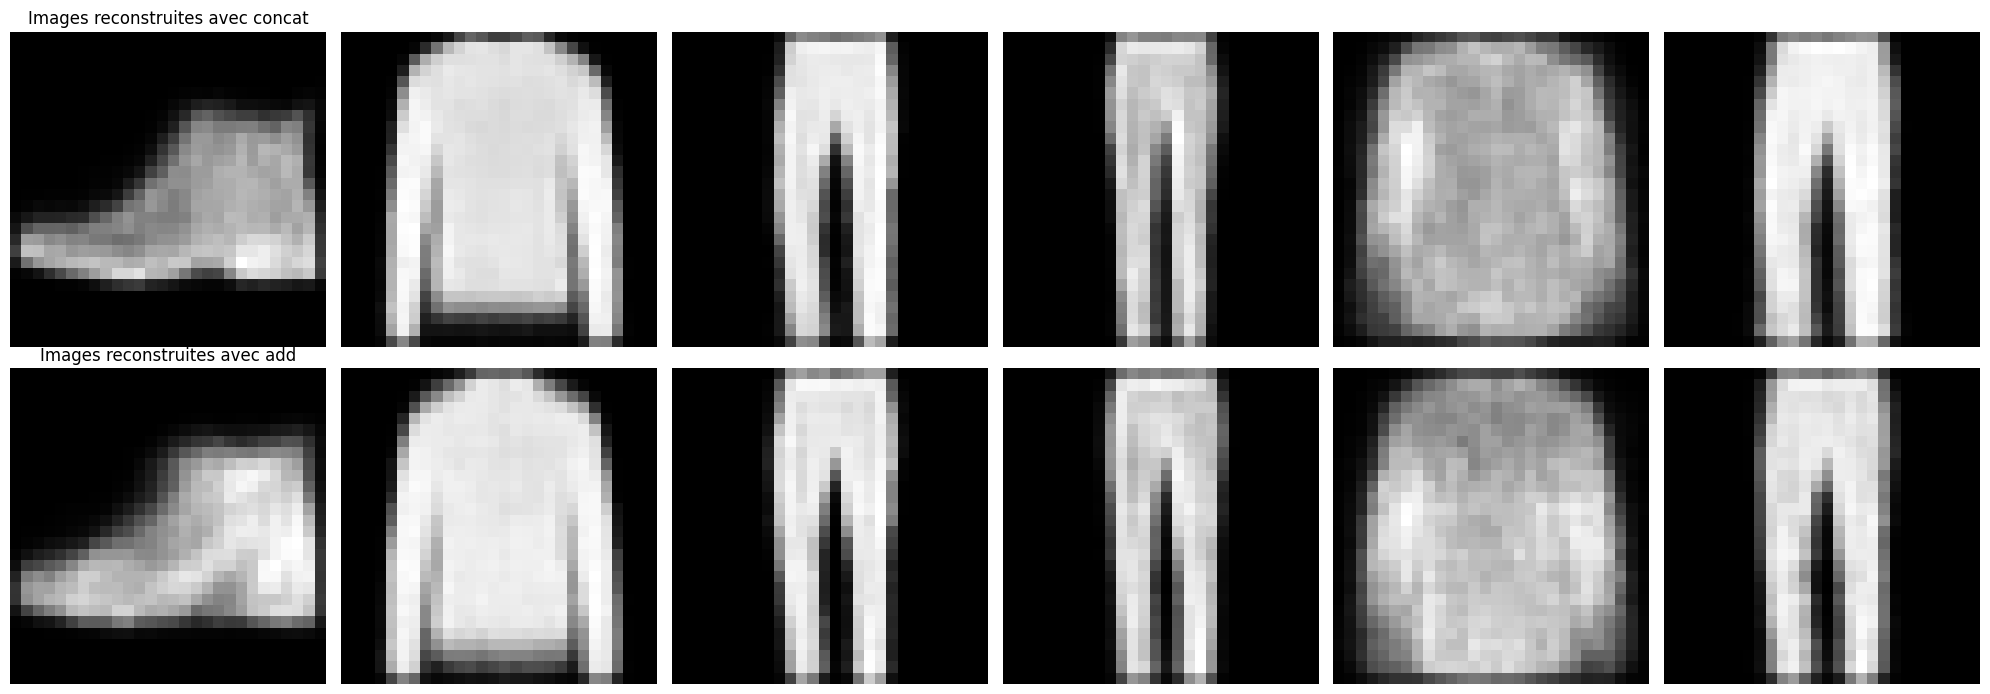

In [90]:
# Select a batch of images from the test dataset
random_images = next(iter(test_loader))

# Get the reconstructions of the selected images
recons_concat, _, _ = vae_concat(random_images[0].to(device), random_images[1].to(device))
recons_add, _, _ = vae_add(random_images[0].to(device), random_images[1].to(device))

# Reshape the images for plotting
random_images = random_images[0].cpu().numpy().squeeze()
recons_concat = recons_concat.detach().cpu().numpy().squeeze()
recons_add = recons_add.detach().cpu().numpy().squeeze()

# Plot the original images and their reconstructions
comparison_images(random_images, "Images originales", recons_concat, "Images reconstruites avec concat")
comparison_images(random_images, "Images originales", recons_add, "Images reconstruites avec add")
comparison_images(recons_concat, "Images reconstruites avec concat", recons_add, "Images reconstruites avec add")

In order to assess model-generated images, 3 quantitative metrics are commonly used. Mean Squared Error (MSE) was calculated by summing the squares of the difference between the generated image and a ground truth image pixel-wise. Structural Similarity Index Measure (SSIM) is a metric that evaluates image quality by comparing two images based on structural information, luminance, and contrast [3]. SSIM can be used to compare images of any size while MSE is relative to pixel size. SSIM score ranges from -1 to 1, where 1 indicates identical images. Frechet inception distance (FID) is a metric for quantifying the realism and diversity of images generated. As FID is a distance measure, lower scores are indicative of a better reconstruction of a set of images.

## Création de 5 échantillons de chaque classe 